# Import Libraries

In [262]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
from scipy.signal import medfilt, find_peaks

In [ ]:
!pip install obspy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.7 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.35
    Uninstalling SQLAlchemy-2.0.35:
      Successfully uninstalled SQLAlchemy-2.0.35
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.54 which is incompatible.


# Read Moon File

In [362]:
data = pd.read_csv('xa.s12.00.mhz.1970-07-20HR00_evid00037.csv').drop('time_abs(%Y-%m-%dT%H:%M:%S.%f)', axis = 1)
data

,time_rel(sec),velocity(m/s)
0,0.000000,-1.462155e-15
1,0.150943,-1.824771e-15
2,0.301887,-1.974266e-15
3,0.452830,-1.886487e-15
4,0.603774,-1.646714e-15
...,...,...
242346,34293.886792,-3.667873e-11
242347,34294.037736,-2.304322e-11
242348,34294.188679,5.754373e-11
242349,34294.339623,1.991547e-10


# Ensuring Static Sample Rate

In [363]:
SR = len(data['time_rel(sec)'].loc[(data['time_rel(sec)'] > 0) & (data['time_rel(sec)'] < 1)])

print(SR)
desired_SR = 5

# Downsample if SR is greater than 5 Hz
if SR > desired_SR:
    # Calculate the downsampling factor (how many samples to skip)
    downsample_factor = int(SR / desired_SR)

    # Downsample the data by taking every 'downsample_factor' point
    downsampled_data = data.iloc[::downsample_factor, :].reset_index(drop=True)
    print(f"Downsampled to {desired_SR} Hz")

    # Optionally, you can print or inspect the new sample rate:
    new_SR = len(downsampled_data.loc[(downsampled_data['time_rel(sec)'] > 0) & (downsampled_data['time_rel(sec)'] < 1)])
    print(f"New Sample Rate: {new_SR} Hz")

    # Print the first few rows of downsampled data
    print(downsampled_data.head(6))

# Explore The Data

In [356]:
data.dropna(inplace = True)
print(data.info())
print()
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542927 entries, 0 to 542926
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   time_rel(sec)  542927 non-null  float64
 1   velocity(m/s)  542927 non-null  float64
dtypes: float64(2)
memory usage: 8.3 MB
None

       time_rel(sec)  velocity(m/s)
count  542927.000000   5.429270e+05
mean    40975.547170  -1.299135e-13
std     23657.308549   2.916590e-10
min         0.000000  -3.738055e-09
25%     20487.773585  -1.555157e-10
50%     40975.547170   1.938066e-12
75%     61463.320755   1.687192e-10
max     81951.094340   3.829678e-09


# Implement optimized Peaks Detection

Filtered Peaks (consecutive in time): 122020    18418.113208
Name: time_rel(sec), dtype: float64


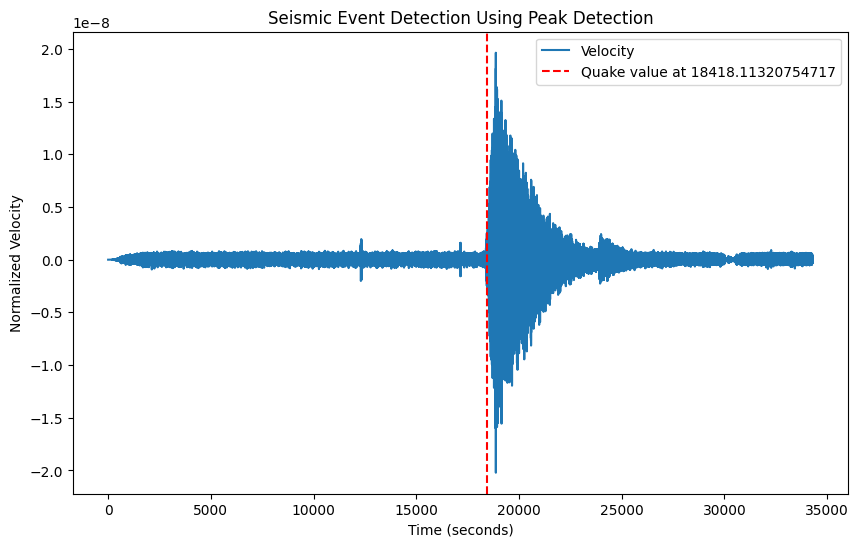

In [363]:
# Detect peaks based on height
peaks, _ = find_peaks(data['velocity(m/s)'], height=1.5E-9)

# Minimum number of consecutive peaks
min_consecutive_peaks = 12

# Calculate time differences between consecutive peaks
time_diff = np.diff(data['time_rel(sec)'][peaks].values).astype('timedelta64[ms]').astype(int)

# Group peaks that occur within a small time window (e.g., less than 500 ms apart)
time_threshold = 1000  # Define time threshold for consecutive peaks in milliseconds
consecutive_groups = np.split(peaks, np.where(time_diff > time_threshold)[0] + 1)

# Filter groups with at least `min_consecutive_peaks`
filtered_peaks = [group[0] for group in consecutive_groups if len(group) >= min_consecutive_peaks]

filtered_peaks = data.loc[filtered_peaks]['time_rel(sec)']
# Print final peaks
print("Filtered Peaks (consecutive in time):", filtered_peaks)


plt.figure(figsize=(10, 6))
plt.plot(data['time_rel(sec)'], data['velocity(m/s)'], label='Velocity')
# plt.ylim(7e-9, -7e-9)


for x in filtered_peaks:
    plt.axvline(x=x, color='red', linestyle='--', label=f'Quake value at {x}')

plt.xlabel('Time (seconds)')
plt.ylabel('Normalized Velocity')
plt.title('Seismic Event Detection Using Peak Detection')
plt.legend()
plt.show()